## IR, RGB 이미지 입력

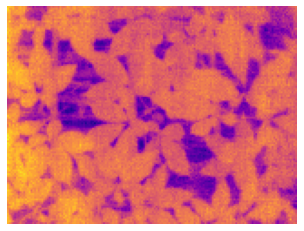

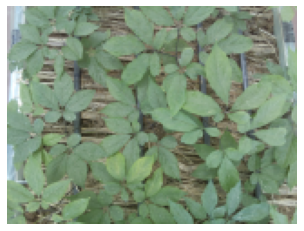

In [1]:
import util

ir_image = util.load_ir_in_dat('./ginseng-ir/irimage_20220728_0903.dat')
rgb_image = util.load_rgb_in_jpeg('./ginseng-rgb/1.jpeg')

util.show_images(ir_image, rgb_image)

## exg 인덱스와 클러스터링 결과
* exg 인덱스는 Excess-green 인덱스로 RGB 이미지에서 Green 채널을 증폭해줌
* 클러스터링은 Jenks Natural Breaks 기법으로 이루어짐

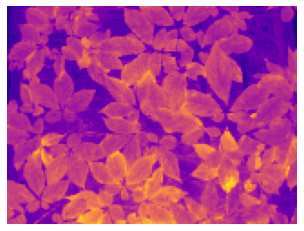

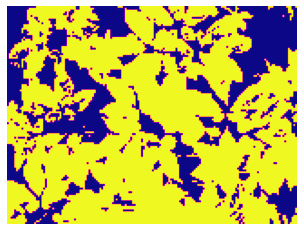

In [2]:
import util

exg = util.get_excess_green(rgb_image)
label = util.get_leaf_with_jenks(exg)

util.show_images(exg, label)

## IR 이미지를 클러스터링
* 클러스터링은 Jenks Natural Breaks 기법으로 이루어짐

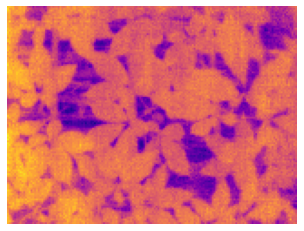

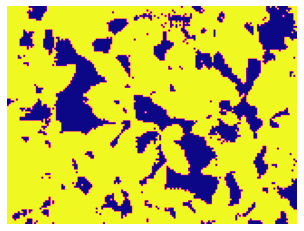

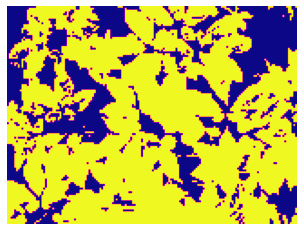

In [3]:
predict = util.get_leaf_with_jenks(ir_image)

util.show_images(ir_image, predict, label)

## 분할 결과 평가
* EXG 인덱스를 클러스터링한 결과와 IR 이미지만으로 클러스터링한 결과와 비교함
* Intersection-Over-Union 지표를 통해 평가함

In [4]:
from sklearn.metrics import confusion_matrix
import util

accuracy = util.get_intersection_over_union(label, predict)
print(f"정확도(IOU, %): {accuracy * 100:.2f}")

average_temperature = util.get_average_temperature(ir_image, predict)
print(f'잎의 평균 온도(C): {average_temperature:.2f}')


정확도(IOU, %): 62.04
잎의 평균 온도(C): 24.44


## experimental
* (온도, 행, 렬)을 feature로 사용해 k-means 알고리즘 사용

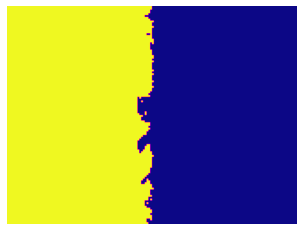

In [5]:
import util

leaf = util.get_leaf_with_kmeans(ir_image)
util.show_images(leaf)